For use with the following docker container image: runpod/pytorch:2.2.0-py3.10-cuda12.1.1-devel-ubuntu22.04 <br>

In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
!pip install gdown
!pip install albumentations==1.4.12
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.ops import StochasticDepth
import time
import math
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm_notebook
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
import seaborn as sns

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


FER2013 dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data <br>
The link is to a copy of 'icml_face_data.csv' on Google Drive.

In [3]:
!gdown --fuzzy 'https://drive.google.com/file/d/1BKl1f9YWCvaQKdJ3B5tSGccPwyaQTV32/view?usp=drive_link'

Downloading...
From (original): https://drive.google.com/uc?id=1BKl1f9YWCvaQKdJ3B5tSGccPwyaQTV32
From (redirected): https://drive.google.com/uc?id=1BKl1f9YWCvaQKdJ3B5tSGccPwyaQTV32&confirm=t&uuid=21b35ca5-930a-4702-b34b-bbf93da6b429
To: /workspace/icml_face_data.csv
100%|████████████████████████████████████████| 301M/301M [00:10<00:00, 28.1MB/s]


Dataset class for loading the FER2013 dataset, and applying augmentations for training and validation. Albumentations library is used for augmentations. <br>
Random shift, scale and rotate is always applied, followed by 80% chance of brightness/contrast, colour shift and noise augmentations. <br>
Coarse dropout is then applied to improve model's ability to recognize partial faces. <br>
Normalization using ImageNet statistics is applied to all images.

In [5]:
# Load and preprocess the data
df = pd.read_csv('/workspace/icml_face_data.csv')


# Define the custom dataset
class EmotionDataset(Dataset):
    def __init__(self, dataframe, augment=False):
        self.dataframe = dataframe
        self.augment = augment
        self.output_size = 224

        # Define augmentations
        self.train_transform = A.Compose([
            A.Resize(height=self.output_size, width=self.output_size, p=1.0),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=20, interpolation=1, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1.0),
                A.RandomGamma(gamma_limit=(80, 120), p=1.0)
            ], p=0.8),
            A.OneOf([
                A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1.0),
                A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=35, val_shift_limit=25, p=1.0),
            ], p=0.8),
            A.OneOf([
                A.GaussNoise(var_limit=(50.0, 300.0), mean=0, per_channel=True, noise_scale_factor=1, p=1.0),
                A.ISONoise(color_shift=(0.1, 0.20), intensity=(0.2, 0.5), p=1.0)
            ], p=0.8),
            A.CoarseDropout(num_holes_range=(3, 4), hole_height_range=(50, 100), hole_width_range=(50, 100), p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        # For validation and testing, only resize and normalize
        self.val_transform = A.Compose([
            A.Resize(height=self.output_size, width=self.output_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Image is stored as a string of pixel values separated by spaces, in row-major order
        # Read the string, convert to a numpy array, and reshape to a 48x48 array
        pixels = np.array(self.dataframe.iloc[idx, 2].split(), dtype=np.uint8).reshape(48, 48)
        label = self.dataframe.iloc[idx, 0]

        pixels = np.stack([pixels] * 3, axis=-1) # Convert grayscale to RGB by duplicating the channels

        if self.augment:
            transformed = self.train_transform(image=pixels)
        else:
            transformed = self.val_transform(image=pixels)

        pixels = transformed['image']

        return pixels, label


# Helper function to calculate class weights
def get_class_weights(dataframe):
    class_counts = dataframe['emotion'].value_counts().sort_index()
    total_samples = len(dataframe)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return class_weights


# Helper function to create a weighted sampler
def create_weighted_sampler(dataframe):
    class_weights = get_class_weights(dataframe)
    sample_weights = [class_weights[label] for label in dataframe['emotion']]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


# Split the dataframe based on the ' Usage' column
splits = {name: group for name, group in df.groupby(' Usage')}
train_df = splits['Training']
test_df = splits['PublicTest']
val_df = splits['PrivateTest']

# Create datasets
train_dataset = EmotionDataset(train_df, augment=True)
val_dataset = EmotionDataset(test_df, augment=False)
test_dataset = EmotionDataset(val_df, augment=False)

# Create sampler
train_sampler = create_weighted_sampler(train_df)

# Create data loaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Define the classes
classes = ("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral")

Display some images from each of the dataloader, to verify the augmentation is working as expected, and that no augmentation is peformed for the validation and test sets.

Training dataset


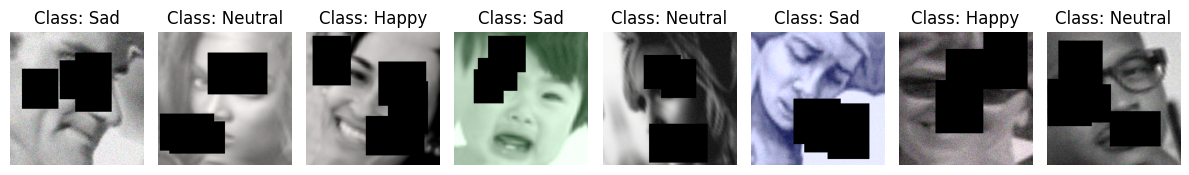

Validation dataset


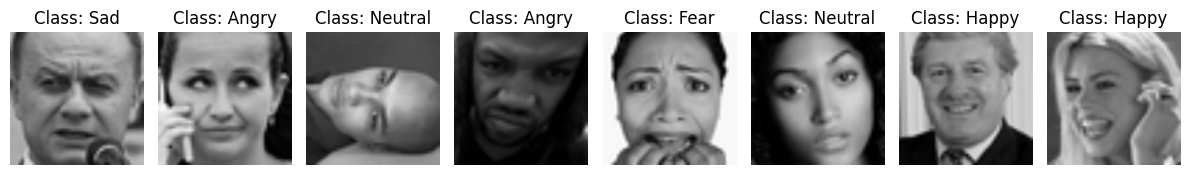

Testing dataset


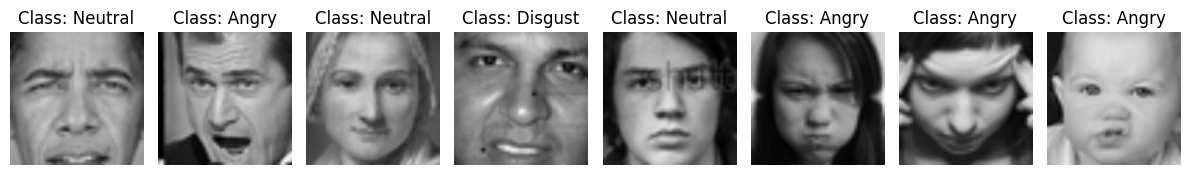

In [6]:
# Transform the tensor back to an image
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor


def display_emotion_samples(dataset, classes, num_samples=8):
    # Set up the plot
    fig, axes = plt.subplots(1, 8, figsize=(12, 3))
    axes = axes.ravel()

    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Get the image and label
        image, label = dataset[idx]
        image = (inverse_normalize(image).permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        # Display the images
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {classes[label]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


print('Training dataset')
display_emotion_samples(train_dataset, classes)
print('Validation dataset')
display_emotion_samples(val_dataset, classes)
print('Testing dataset')
display_emotion_samples(test_dataset, classes)

Check the class distribution in the original dataset.

In [7]:
def print_class_distribution(dataframe):
    count = dataframe['emotion'].value_counts().sort_index()
    class_distribution = {classes[i]: count for i, count in count.items()}
    print('Class distribution')
    for class_name, count in class_distribution.items():
        print(f'{class_name:10s}: {count}')


print('\nTraining')
print_class_distribution(train_df)
print('\nValidation')
print_class_distribution(val_df)
print('\nTesting')
print_class_distribution(test_df)

Training
Class distribution
Angry     : 3995
Disgust   : 436
Fear      : 4097
Happy     : 7215
Sad       : 4830
Surprise  : 3171
Neutral   : 4965
Validation
Class distribution
Angry     : 491
Disgust   : 55
Fear      : 528
Happy     : 879
Sad       : 594
Surprise  : 416
Neutral   : 626
Testing
Class distribution
Angry     : 467
Disgust   : 56
Fear      : 496
Happy     : 895
Sad       : 653
Surprise  : 415
Neutral   : 607


Verify the sampler is working as intended. The minority classes should be oversampled, and an equal amount of images from each classes is fed into the model at each epoch.

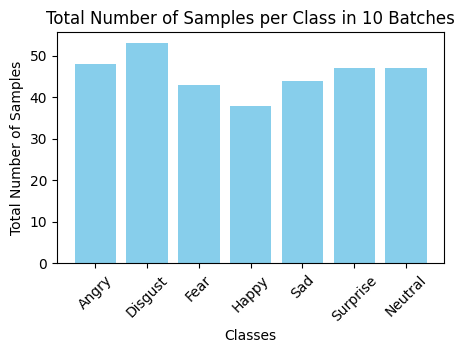

In [9]:
def verify_sampler(dataloader, classes, num_batches=10):
    class_counts = {cls: 0 for cls in classes}

    for _ in range(num_batches):
        batch = next(iter(dataloader))
        labels = batch[1].numpy()
        label_count = Counter(labels)

        for cls_idx, count in label_count.items():
            class_counts[classes[cls_idx]] += count

    # Plot the total number of samples per class
    plt.figure(figsize=(5, 3))
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Total Number of Samples")
    plt.title(f"Total Number of Samples per Class in {num_batches} Batches")
    plt.xticks(rotation=45)
    plt.show()


# Call the function to verify the sampler
verify_sampler(trainloader, classes, num_batches=10)

Define the EmoNeXt network. Adapted from https://github.com/yelboudouri/EmoNeXt

In [10]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class DotProductSelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(DotProductSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.norm = nn.LayerNorm(input_dim)
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.norm(x)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        scale = 1 / math.sqrt(math.sqrt(self.input_dim))
        scores = torch.matmul(query, key.transpose(-2, -1)) * scale
        attention_weights = torch.softmax(scores, dim=-1)

        attended_values = torch.matmul(attention_weights, value)
        output = attended_values + x

        return output, attention_weights


class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


class Block(nn.Module):
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(
            dim, dim, kernel_size=7, padding=3, groups=dim
        )  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(
            dim, 4 * dim
        )  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )
        self.stochastic_depth = StochasticDepth(drop_path, "row")

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.stochastic_depth(x)
        return x


class EmoNeXt(nn.Module):
    def __init__(
            self,
            in_chans=3,
            num_classes=1000,
            depths=None,
            dims=None,
            drop_path_rate=0.0,
            layer_scale_init_value=1e-6,
    ):
        super().__init__()

        if dims is None:
            dims = [96, 192, 384, 768]
        if depths is None:
            depths = [3, 3, 9, 3]

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(nn.Linear(10 * 52 * 52, 32), nn.ReLU(True), nn.Linear(32, 3 * 2))

        self.downsample_layers = (nn.ModuleList())
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
                SELayer(dims[i + 1]),
            )
            self.downsample_layers.append(downsample_layer)

        # 4 feature resolution stages, each consisting of multiple residual blocks
        self.stages = (nn.ModuleList())

        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                    for j in range(depths[i])
                ]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.attention = DotProductSelfAttention(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
        )

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)

        return x

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x, labels=None):
        x = self.stn(x)
        x = self.forward_features(x)
        _, weights = self.attention(x)
        logits = self.head(x)

        if labels is not None:
            mean_attention_weight = torch.mean(weights)
            attention_loss = torch.mean((weights - mean_attention_weight) ** 2)

            loss = F.cross_entropy(logits, labels, label_smoothing=0.2) + attention_loss
            return logits, torch.argmax(logits, dim=1), loss

        return logits, torch.argmax(logits, dim=1)


def get_model(num_classes=7):
    depths = [3, 3, 27, 3]
    dims = [96, 192, 384, 768]
    url = ('https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth')
    net = EmoNeXt(
        depths=depths, dims=dims, num_classes=21841, drop_path_rate=0.1
    )

    state_dict = load_state_dict_from_url(url=url)
    net.load_state_dict(state_dict["model"], strict=False)
    net.head = nn.Linear(dims[-1], num_classes)

    return net

In [11]:
model = get_model()
print(f"Total params {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth
100%|██████████| 170M/170M [00:01<00:00, 145MB/s]  


Total params 52198891


Helper functions for training and save/load checkpoints, to allow for resuming training. Mixed precision is used to speed up training

In [12]:
# Saves the model checkpoint, along with the optimizer and scheduler states
def save_checkpoint(epoch, model, optimizer, scheduler, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(checkpoint, filename)


# Loads the model checkpoint, along with the optimizer and scheduler states
def load_checkpoint(filename, model, optimizer, scheduler):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']


def train_model(model, optimizer, scheduler, start_epoch, total_epoch):
    start_time = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Starting training using device: {device}")

    # Required for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    model = model.to(device)

    num_epochs = total_epoch - start_epoch
    current_epoch = start_epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        iters = len(trainloader)

        # Training
        with tqdm_notebook(total=len(trainloader),
                           desc=f"E {current_epoch + 1}/{total_epoch} Train",
                           unit="batch") as pbar:
            for i, data in enumerate(trainloader, 0):
                input, labels = data
                input, labels = input.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    logits, predictions, loss = model(input, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # CosineAnnealingWarmRestarts requires updating the scheduler after each batch
                scheduler.step(current_epoch + i / iters)
                
                running_loss += loss.item()
                current_lr = scheduler.get_last_lr()
                current_loss = running_loss / (i + 1)

                pbar.set_postfix({
                    "loss": f"{current_loss:.3f}",
                    "lr": f"{current_lr[0]:.5f}"
                })
                pbar.update(1)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            with tqdm_notebook(total=len(valloader),
                               desc=f"E {current_epoch + 1}/{total_epoch} Val  ",
                               unit="batch") as pbar:
                for i, data in enumerate(valloader):
                    input, labels = data
                    input, labels = input.to(device), labels.to(device)
                    logits, predictions, loss = model(input, labels)
                    val_loss += loss.item()
                    total += labels.size(0)
                    correct += (predictions == labels).sum().item()
                    running_accuracy = 100 * correct / total
                    current_loss = val_loss / (i + 1)

                    pbar.set_postfix({
                        "loss": f"{current_loss:.3f}",
                        "accuracy": f"{running_accuracy:.5f}%"
                    })
                    pbar.update(1)

        save_checkpoint(current_epoch, model, optimizer, scheduler, f'ckpt_net_{current_epoch}.pth')
        current_epoch += 1

    print("Training completed in %s seconds" % (time.time() - start_time))

Train the model

In [13]:
num_epochs = 20
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=1e-4,
                        weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=3)

train_model(model, optimizer, scheduler, 0, num_epochs)

# To resume training, uncomment these lines and specify the checkpoint file
# checkpoint_file = '/workspace/net_20.pth'  # Replace X with the epoch number
# start_epoch = load_checkpoint(checkpoint_file, model, optimizer, scheduler)
# train_model(model, optimizer, scheduler, start_epoch, num_epochs, switch_epoch)

Starting training using device: cuda:0


E 1/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 1/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 2/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 2/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 3/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 3/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 4/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 4/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 5/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 5/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 6/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 6/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 7/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 7/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 8/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 8/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 9/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 9/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 10/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 10/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 11/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 11/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 12/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 12/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 13/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 13/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 14/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 14/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 15/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 15/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 16/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 16/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 17/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 17/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 18/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 18/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 19/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 19/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

E 20/20 Train[<class 'type'>]:   0%|          | 0/898 [00:00<?, ?batch/s]

E 20/20 Val    :   0%|          | 0/113 [00:00<?, ?batch/s]

Training completed in 3300.6697669029236 seconds


Saves only the model weights

In [ ]:
torch.save(model.state_dict(), '/workspace/EmoNeXt.pth')

Check the accuracy using the testing dataset. Plot the confusion matrix and calculate the per-class precision, recall, and F1-score.

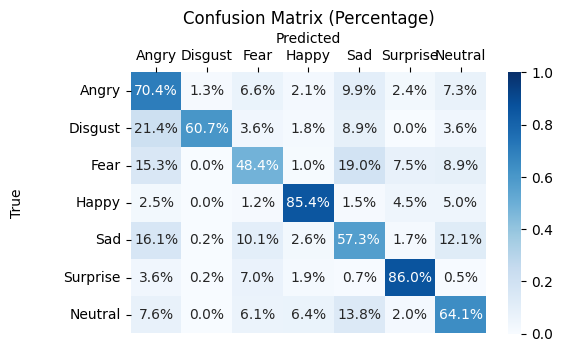


Per-class Precision, Recall, and F1-score:
Angry: Precision: 54.38%, Recall: 70.45%, F1-score: 0.61
Disgust: Precision: 80.95%, Recall: 60.71%, F1-score: 0.69
Fear: Precision: 57.69%, Recall: 48.39%, F1-score: 0.53
Happy: Precision: 90.52%, Recall: 85.36%, F1-score: 0.88
Sad: Precision: 60.42%, Recall: 57.27%, F1-score: 0.59
Surprise: Precision: 76.28%, Recall: 86.02%, F1-score: 0.81
Neutral: Precision: 65.38%, Recall: 64.09%, F1-score: 0.65


In [15]:
def evaluate_model(model, valloader, classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            logits, predictions, _ = model(inputs, labels)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


def plot_confusion_matrix(all_predictions, all_labels, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt='.1%', cmap='Blues', xticklabels=classes, yticklabels=classes, vmin=0,
                vmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Percentage)')

    ax = plt.gca()
    ax.set_yticklabels([f'{classes[i]}' for i in range(len(classes))])
    ax.yaxis.set_tick_params(rotation=0)
    ax.yaxis.set_label_coords(-0.3, 0.5)

    plt.tight_layout()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    plt.show()

    print("\nPer-class Precision, Recall, and F1-score:")
    for i, class_name in enumerate(classes):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{class_name}: Precision: {precision:.2%}, Recall: {recall:.2%}, F1-score: {f1_score:.2f}")


all_predictions, all_labels = evaluate_model(model, valloader, classes)
plot_confusion_matrix(all_predictions, all_labels, classes)